In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!sudo apt-get install libportaudio2
!pip install sounddevice

In [ ]:
import os
import numpy as np
import pylab as plt
import scipy.signal as sg
import sounddevice as sd
import pandas as pd

from time import sleep

from IPython.display import Audio, display
def play(x, fs):
    display(Audio(x, rate=fs))

In [ ]:
from sklearn.model_selection import train_test_split

# load data
data_dir = '/content/drive/MyDrive/НИС АДИС 2022/data_project'
x_global_train = np.load(os.path.join(data_dir, 'train.npz'))['x']
y_global_train = np.load(os.path.join(data_dir, 'train.npz'))['y']
x_global_test  = np.load(os.path.join(data_dir, 'test.npz'))['x']

# split train dataset into local train and test
x_train, x_test, y_train, y_test = train_test_split(x_global_train, y_global_train, shuffle=True)
fs = 16000

print(x_test.shape, y_test.shape, x_global_test.shape)

(563, 16000) (563,) (750, 16000)


In [ ]:
# play a few samples
for k in np.random.choice(np.arange(len(x_train)), 3):
    print(int(y_train[k]))
    play(x_train[k], fs)
    sleep(1.2)

3


3


1


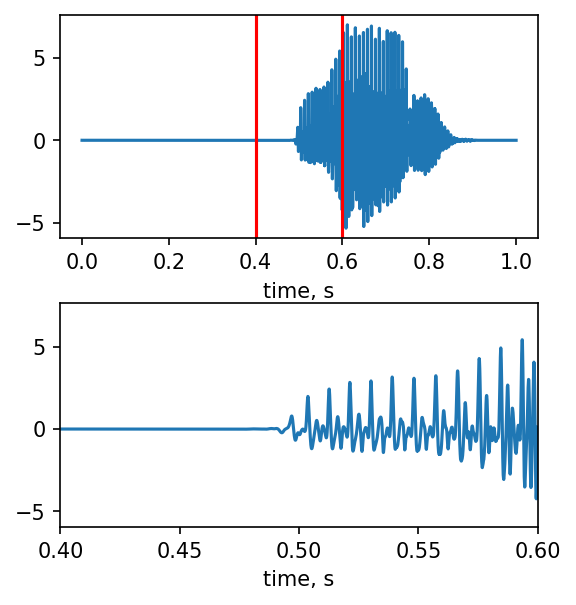

In [ ]:
# plot some sample
fig, ax = plt.subplots(2, figsize=(4,4), dpi=150)
plt.tight_layout()

x = x_train[y_train==1][0]

time = np.arange(len(x))/fs

segment = [0.4, 0.6]
ax[0].plot(time, x)
ax[0].set_xlabel('time, s')
[ax[0].axvline(b, color='r') for b in segment]
ax[1].plot(time, x)
ax[1].set_xlim(segment)
ax[1].set_xlabel('time, s')
play(x, fs)

(129,) (1687, 129)


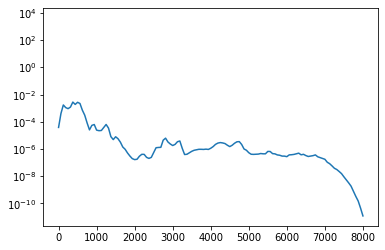

In [ ]:
# plot a spectrum of some sample
freq, x_spec_train = sg.welch(x_train, fs, axis=1, )
print(freq.shape, x_spec_train.shape)
plt.plot(freq, x_spec_train[y_train==1][1])
plt.semilogy(0, 4000)

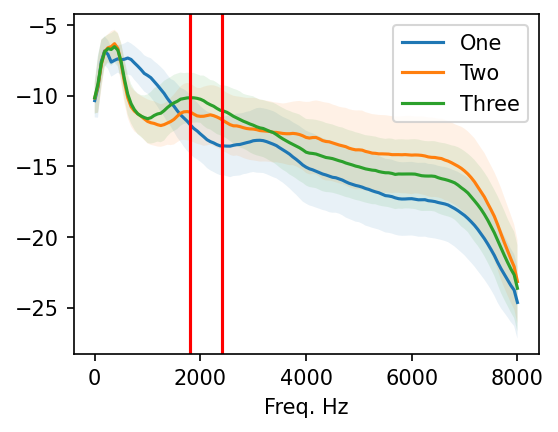

In [ ]:
# average spectums for each class
fig, ax = plt.subplots(1, figsize=(4,3), dpi=150)
for k in range(1, 3+1):
    specs = np.log(x_spec_train[y_train==k])
    plt.plot(freq, specs.mean(0), label=['One', 'Two', 'Three'][k-1])
    plt.fill_between(freq, specs.mean(0)-specs.std(0), specs.mean(0)+specs.std(0), alpha=0.1)
    
plt.legend()
plt.xlabel('Freq. Hz')
band = (1800, 2400)
[plt.axvline(b, color='r') for b in band]

In [ ]:
# define features transformer
def extract_features(x, band):
    freq, spec = sg.welch(x, fs, axis=1)
    features = spec[:, (freq>band[0]) & (freq<band[1])].mean(1).reshape(-1, 1)
    return features

In [ ]:
# extract features
f_train = extract_features(x_train, band)
f_test  = extract_features(x_test, band)
f_global_test = extract_features(x_global_test, band)

In [ ]:
# fit model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

classifier = DecisionTreeClassifier()
classifier.fit(f_train, y_train)

DecisionTreeClassifier()

In [ ]:
# collect predictions
y_train_pred = classifier.predict(f_train).astype(int)
y_test_pred = classifier.predict(f_test).astype(int)
y_global_test_pred = classifier.predict(f_global_test).astype(int)

accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.6467101363366924, 0.46181172291296624)

In [ ]:
# play a few predictions
print('{:12s} {:12s} {:12s}'.format('prediction', 'actual', 'error'))
for k in np.random.choice(np.arange(len(x_test)), 2):
    play(x_test[k], fs)
    print('{:12s} {:12s} {}'.format(str(int(y_test_pred[k])), str(int(y_test[k])), y_test_pred[k]==y_test[k]))
    sleep(1.2)

prediction   actual       error       


1            1            True


1            2            False


In [ ]:
# save test data predictions
from google.colab import files

df = pd.DataFrame(data=y_global_test_pred, columns=['Category'])
df.to_csv('results.csv', index_label='Id')
df

,Category
0,1
1,1
2,1
3,1
4,1
...,...
745,2
746,1
747,1
748,3


In [ ]:
df = pd.DataFrame(data=y_global_test_pred*0 + 1, columns=['Category'])
df.to_csv('all_one_results.csv', index_label='Id')
df

,Category
0,1
1,1
2,1
3,1
4,1
...,...
745,1
746,1
747,1
748,1
